In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

import optuna

import pickle


Using TensorFlow backend.


In [2]:

with open('lgbm_final_classifier.pickle', 'rb') as file:
    lgbm_final_classifier = pickle.load(file)

In [7]:
lgbm_final_classifier.feature_importances_

array([1722,  187,  155,  143,  138,  173,  357,  218,  335, 1166,  325,
        102,  310,  585,  513,  617,  282,  686,  699,  991,  712, 1025,
         62,   20,   12,   76,  262,   62,   27,  124,  100,   30,   46,
         82,  295,   80,  275,  212,   58,  359,   41,   12,   35,    3,
         32,    9,   94,   18,    1,    2,   33,   50,    4,    0,    0,
          5,    3,   39,   14,  100,   26,   83,   50,   47,  181,   46,
         11,   22,    1,    0,   35,    2,    9,    7,   13,    7,    4,
         28,   15,    0,    0,    0,    0,   50,   80,   85,  224,  106,
         14,  107,    5,  144,  115,   67,    6,    3,    3,   35,   35,
          3,  253,   35,  355,    0,  185,   62,  230,   67,    4,   38,
         27,    9,   12,   75,   88,  110,   50,  151,   62,    2,  275,
        108,  105,    0,  107,   62,    7,   12,   35,   40,   74,    7,
         92,   55,   16,    9,   25,    1,   33,    0,    0,    8,   22,
         15,   17,   29,   24,   40,   51,   33,   

In [8]:
df = pd.read_csv('does_it_work.csv')
len(df.columns)

91

In [9]:
with open('ohe_final.pickle', 'rb') as file:
    ohe_final = pickle.load(file)

In [10]:
X = df.drop(columns=['HICOV'])
y = df['HICOV']

In [12]:
continuous_columns = ['AGEP','INTP_cat','OIP_cat','RETP_cat','SEMP_cat','SSIP_cat','JWAP_mins','JWDP_mins','TOTAL_commute','PWGTP_y','JWMNP','PAP','SSP','WAGP','WKHP','OCCP','PERNP','PINCP',
                     'FINCP','HINCP','MAR_YEARS','NP']
categorical_columns = [x for x in X.columns if x not in continuous_columns]

In [13]:
_X_final_ohe = ohe_final.transform(X[categorical_columns]).toarray()
_X_final_ohe_df = pd.DataFrame(data = _X_final_ohe,
                        columns = ohe_final.get_feature_names(categorical_columns))

In [14]:
with open('scaler_final.pickle', 'rb') as file:
    scaler_final = pickle.load(file)

In [15]:
_X_final_cont = scaler_final.transform(X[continuous_columns])
_X_final_cont_df = pd.DataFrame(data = _X_final_cont,
                         columns = continuous_columns)

In [16]:
_X_final_merged = _X_final_cont_df[continuous_columns].merge(_X_final_ohe_df, left_index=True, right_index=True)
_X_final_merged

,AGEP,INTP_cat,OIP_cat,RETP_cat,SEMP_cat,SSIP_cat,JWAP_mins,JWDP_mins,TOTAL_commute,PWGTP_y,...,SOCP_recat_MGR,SOCP_recat_MIL,SOCP_recat_None,SOCP_recat_OFF,SOCP_recat_PRD,SOCP_recat_PRS,SOCP_recat_PRT,SOCP_recat_SAL,SOCP_recat_SCI,SOCP_recat_TRN
0,-1.239857,-0.125537,-0.134285,-0.245213,-0.111282,-0.169387,-0.955794,-0.936232,-0.740011,0.619286,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.502367,-0.125537,-0.134285,-0.245213,-0.111282,-0.169387,3.677445,3.879619,-0.196193,-0.701801,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.659874,-0.125537,-0.134285,-0.245213,-0.111282,-0.169387,-0.955794,-0.936232,-0.740011,-0.118968,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.857764,-0.125537,-0.134285,-0.245213,-0.111282,-0.169387,-0.955794,-0.936232,-0.740011,0.153020,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.607372,-0.125537,-0.134285,-0.245213,-0.111282,-0.169387,2.019233,2.171870,-0.558738,-0.183727,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159294,-0.714837,-0.125537,-0.134285,-0.245213,-0.111282,-0.169387,0.751189,0.686129,1.072714,0.204827,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
159295,-0.609832,-0.125537,-0.134285,-0.245213,-0.111282,-0.169387,0.734932,0.686129,0.891442,0.412057,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
159296,-1.187355,-0.125537,-0.134285,-0.245213,-0.111282,-0.169387,0.344765,0.378734,-0.196193,-0.054209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
159297,0.335204,-0.125537,-0.134285,-0.245213,-0.111282,-0.169387,0.621133,0.549509,1.072714,-0.365053,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


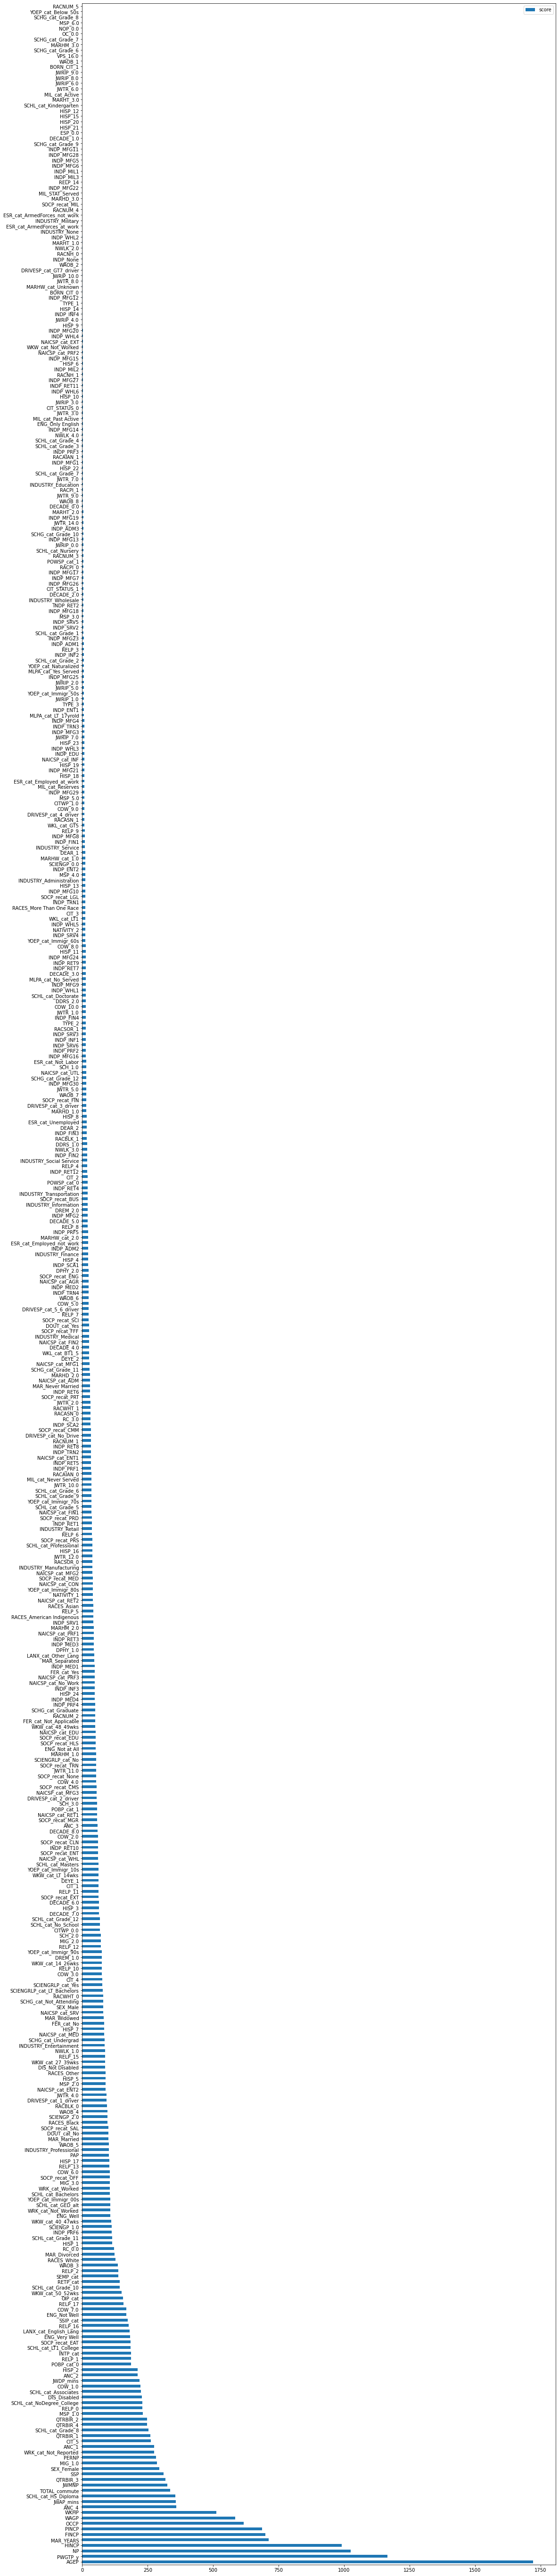

In [25]:
plot_features = pd.DataFrame(data = lgbm_final_classifier.feature_importances_, index=_X_final_merged.columns, columns = ['score']).sort_values(by='score', ascending=False)

plot_features.plot(kind='barh', figsize=(18,100))
